## Knowledge Graph
#### Drug-Food or Drug-Supplements interaction prediction

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pykeen.models import predict
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
from pykeen.models import TransE
from pykeen.evaluation import RankBasedEvaluator

from os import listdir

### Split data into train, validation and test sets

In [13]:
data_dir = 'data/triplets/'

In [14]:
ddi_df = pd.read_csv(data_dir + 'ddi.tsv', sep='\t', index_col=[0])
ddi_df.head()

,drug1,interaction,drug2
0,Apixaban,increase_anticoagulant_activities,Lepirudin
1,Dabigatran etexilate,increase_anticoagulant_activities,Lepirudin
2,Dasatinib,increase_bleeding,Lepirudin
3,Dasatinib,increase_hemorrhage,Lepirudin
4,Deferasirox,increase_gastrointestinal_bleeding,Lepirudin


In [15]:
print('total interactions:', ddi_df.shape[0])
print('unique interactions:', len(set(ddi_df.interaction)))

interaction_counts = ddi_df.groupby(by=['interaction']).size()
interaction_counts

total interactions: 3123450
unique interactions: 205


interaction
decrease_absorption                             576
decrease_adverse_effects                        384
decrease_anticholinergic_activities              26
decrease_anticoagulant_activities              5174
decrease_antihypertensive_activities          63420
                                              ...  
increase_visual_accommodation_disturbances        2
increase_vomiting                                54
increase_water_intoxication                     256
increase_weakness                              1710
increase_weight_gain                             16
Length: 205, dtype: int64

In [16]:
set(ddi_df.interaction)

{'decrease_absorption',
 'decrease_adverse_effects',
 'decrease_anticholinergic_activities',
 'decrease_anticoagulant_activities',
 'decrease_antihypertensive_activities',
 'decrease_antiplatelet_activities',
 'decrease_arrhythmogenic_activities',
 'decrease_bioavailability',
 'decrease_bronchodilatory_activities',
 'decrease_cardiotoxicity',
 'decrease_cytotoxicity',
 'decrease_diuretic_activities',
 'decrease_effectiveness',
 'decrease_excretion_rate',
 'decrease_fluid_retaining_activities',
 'decrease_hypertension',
 'decrease_hypoglycemia',
 'decrease_hypotension',
 'decrease_metabolism',
 'decrease_myopathy',
 'decrease_nephrotoxicity',
 'decrease_neuromuscular_blockade',
 'decrease_protein_binding',
 'decrease_qtc_prolongation',
 'decrease_rhabdomyolysis',
 'decrease_sedation',
 'decrease_seizure',
 'decrease_serum_concentration',
 'decrease_skeletal_muscle_relaxing_activities',
 'decrease_stimulatory_activities',
 'decrease_therapeutic_efficacy',
 'decrease_vasoconstricting_acti

In [17]:
drug_supplement_df = pd.read_csv(data_dir + 'ds_relations.tsv', sep='\t', index_col=[0])
# drug_supplement_df = drug_supplement_df[drug_supplement_df['REL'] != 'has_ingredient']
drug_supplement_df.head()

,CUI1,REL,CUI2
689301,1-Androsten-3beta-ol-17-one,interacts_with,Testosterone
689302,4-DHEA,interacts_with,Testosterone
689319,Blackbush,interacts_with,Cytochrome P450 2D6
689320,Blackbush,interacts_with,TOPICAL DRUGS
689322,Blackbush,interacts_with,Cytochrome P450 3A4 substrates


In [18]:
print('total interactions:', drug_supplement_df.shape[0])
print('unique interactions:', len(set(drug_supplement_df.REL)))

ds_interaction_counts = drug_supplement_df.groupby(by=['REL']).size()
ds_interaction_counts

total interactions: 3057
unique interactions: 1


REL
interacts_with    3057
dtype: int64

In [19]:
interactions_count = pd.concat([interaction_counts, ds_interaction_counts])
interactions_count.to_csv('interaction_counts.csv', header=['interaction_count'])

In [20]:
def compute_size(n):
    if n == 2:
        return 1, 1
    if n == 3:
        return 1, 2
    if n == 4:
        return 2, 3
    if n == 5:
        return 3, 4
    if n == 6:
        return 4, 5
    # n == 7
    return 4, 6 

In [21]:
# train : valid : test = 80 : 10 : 10
def split_data_relation(df_relation):
    
    # too few triplets with the realtion
    if df_relation.shape[0] <= 7:
        train_size, valid_size = compute_size(df_relation.shape[0])
        
        # shuffle df_relation
        df_relation = df_relation.sample(frac=1, random_state=42)
        
        X_train = df_relation.iloc[:train_size]
        X_valid = df_relation.iloc[train_size:valid_size]
        X_test = df_relation.iloc[valid_size:]

    else:
        X_train, X_rem = train_test_split(df_relation, train_size=0.8, random_state=42)
        X_valid, X_test = train_test_split(X_rem, test_size=0.5, random_state=42)
        
    return X_train, X_valid, X_test

In [22]:
# split drug-supplements relation dataset
def split_drug_supplements_dataset(drug_supplement_df):
    relations = set(drug_supplement_df.REL)
    
    train_triplets = pd.DataFrame(columns=['CUI1', 'REL', 'CUI2'])
    valid_triplets = pd.DataFrame(columns=['CUI1', 'REL', 'CUI2'])
    test_triplets = pd.DataFrame(columns=['CUI1', 'REL', 'CUI2'])

    for rel in relations:
        train, valid, test = split_data_relation(drug_supplement_df[drug_supplement_df['REL'] == rel])
        train_triplets = pd.concat([train_triplets, train])
        valid_triplets = pd.concat([valid_triplets, valid])
        test_triplets = pd.concat([test_triplets, test])

    train_triplets.rename(columns={'CUI1': 'head', 'REL': 'relation', 'CUI2': 'tail'}, inplace=True)
    valid_triplets.rename(columns={'CUI1': 'head', 'REL': 'relation', 'CUI2': 'tail'}, inplace=True)
    test_triplets.rename(columns={'CUI1': 'head', 'REL': 'relation', 'CUI2': 'tail'}, inplace=True)    


    print('train dataset size:', train_triplets.shape[0])
    print('validation dataset size:',valid_triplets.shape[0])
    print('test dataset size:',test_triplets.shape[0])
    
    return train_triplets, valid_triplets, test_triplets

In [23]:
# split drug-drug interaction dataset (from DrugBank)
def split_ddi_dataset(ddi_df):
    interactions = set(ddi_df.interaction)
    
    train_triplets = pd.DataFrame(columns=['drug1', 'interaction', 'drug2'])
    valid_triplets = pd.DataFrame(columns=['drug1', 'interaction', 'drug2'])
    test_triplets = pd.DataFrame(columns=['drug1', 'interaction', 'drug2'])
    
    for inter in interactions:
        train, valid, test = split_data_relation(ddi_df[ddi_df['interaction'] == inter])
        train_triplets = pd.concat([train_triplets, train])
        valid_triplets = pd.concat([valid_triplets, valid])
        test_triplets = pd.concat([test_triplets, test])
        
    train_triplets.rename(columns={'drug1': 'head', 'interaction': 'relation', 'drug2': 'tail'}, inplace=True)
    valid_triplets.rename(columns={'drug1': 'head', 'interaction': 'relation', 'drug2': 'tail'}, inplace=True)
    test_triplets.rename(columns={'drug1': 'head', 'interaction': 'relation', 'drug2': 'tail'}, inplace=True)    


    print('train dataset size:', train_triplets.shape[0])
    print('validation dataset size:',valid_triplets.shape[0])
    print('test dataset size:',test_triplets.shape[0])
    
    return train_triplets, valid_triplets, test_triplets    
    

In [24]:
# DrugBank drug-drug interactions
print('DrugBank drug-drug interactions')
train_triplets_ddi, valid_triplets_ddi, test_triplets_ddi = split_ddi_dataset(ddi_df)

print()

# Drug Supplement database - drug-suplement interactions
print('Drug Supplement database - drug-suplement interactions')
train_triplets_ds, valid_triplets_ds, test_triplets_ds = split_drug_supplements_dataset(drug_supplement_df)

DrugBank drug-drug interactions
train dataset size: 2498661
validation dataset size: 312349
test dataset size: 312440

Drug Supplement database - drug-suplement interactions
train dataset size: 2445
validation dataset size: 306
test dataset size: 306


In [25]:
# all interactions
train_triplets = pd.concat([train_triplets_ddi, train_triplets_ds])
valid_triplets = pd.concat([valid_triplets_ddi, valid_triplets_ds])
test_triplets = pd.concat([test_triplets_ddi, test_triplets_ds])

print('All interactions:')
print('train dataset size:', train_triplets.shape[0])
print('validation dataset size:',valid_triplets.shape[0])
print('test dataset size:',test_triplets.shape[0])

All interactions:
train dataset size: 2501106
validation dataset size: 312655
test dataset size: 312746


In [26]:
all_relations = set(train_triplets.relation)
print('Number of unique interactions:', len(all_relations))
print(list(all_relations)[:10])

Number of unique interactions: 206
['increase_sedation', 'decrease_anticholinergic_activities', 'increase_anemia', 'increase_tardive_dyskinesia', 'decrease_serum_concentration', 'increase_nausea', 'increase_hypercoagulability', 'increase_death', 'increase_metabolism', 'increase_bronchoconstrictory_activities']


#### Add rest of the data into the training set

In [27]:
files = listdir(data_dir)

for file in files:
    if file == 'ddi.tsv' or file == '.ipynb_checkpoints' or file == 'ds_relations.tsv':
        continue
    if 'train' in file or 'valid' in file or 'test' in file:
        continue
           
    df = pd.read_csv(data_dir + file, sep='\t', index_col=[0])
    
    # if file == 'ds_relations.tsv':
    #     df = df[df['REL'] == 'has_ingredient']
    
    df.set_axis(['head', 'relation', 'tail'], axis=1, inplace=True) 
    train_triplets = pd.concat([train_triplets, df])
    
print('Final size of train dataset (with other relations):', train_triplets.shape[0]) 

Final size of train dataset (with other relations): 3799697


In [28]:
train_triplets = train_triplets.astype(str)
valid_triplets = valid_triplets.astype(str)
test_triplets = test_triplets.astype(str)

In [19]:
# save train, valid and test datasets

train_triplets.to_csv(data_dir + 'train.tsv', sep='\t')
valid_triplets.to_csv(data_dir + 'valid.tsv', sep='\t')
test_triplets.to_csv(data_dir + 'test.tsv', sep='\t')

#### Convert datasets into Triples Factory format

In [29]:
def convert_to_triples_factory(data):
    tf_data = TriplesFactory.from_labeled_triples(
      data[["head", "relation", "tail"]].values,
      create_inverse_triples=False,
      entity_to_id=None,
      relation_to_id=None,
      compact_id=False 
    )
    print(tf_data)  # kam mizeji nejake trojice? - jiny pocet zde a po vytvoreni datasetu
    return tf_data

In [30]:
tf_train = convert_to_triples_factory(train_triplets)
tf_valid = convert_to_triples_factory(valid_triplets)
tf_test = convert_to_triples_factory(test_triplets)


TriplesFactory(num_entities=597163, num_relations=215, create_inverse_triples=False, num_triples=3650539)
TriplesFactory(num_entities=4565, num_relations=183, create_inverse_triples=False, num_triples=312528)
TriplesFactory(num_entities=4529, num_relations=206, create_inverse_triples=False, num_triples=312641)


In [32]:
# take just subset of data for testing

train_sub, _ = tf_train.split(0.15)
valid_sub, _ = tf_valid.split(0.15)
test_sub, _ = tf_test.split(0.15)

using automatically assigned random_state=970934743


ValueError: Could not find a coverage of all entities and relation with only 547580 triples.

In [23]:
train_sub

TriplesFactory(num_entities=647147, num_relations=219, create_inverse_triples=False, num_triples=601202)

### Model

In [ ]:
# evaluation_relation_whitelist = all_relations

In [ ]:
# creating a model
result = pipeline(
    training=train_sub,
    testing=test_sub,
    validation=valid_sub,
    model='TransE',
    epochs=1,
    evaluator=RankBasedEvaluator,
#     model_kwargs=dict(embedding_dim=128),
    device='gpu',
    optimizer='Adam',
#     evaluation_relation_whitelist=evaluation_relation_whitelist,
#     training_kwargs=dict(
#         num_epochs=2,
#         checkpoint_name='transE_checkpoint.pt',
#         checkpoint_directory='kg_ckeckpoints',
#         checkpoint_frequency=0
#     ),
)

In [ ]:
result.plot()

In [ ]:
hits_at_10 = result.get_metric('hits@10')
hits_at_10

In [ ]:
result.training

In [ ]:
# predictions

# model = result.model

# predictions_df = predict.get_prediction_df(
#     model, 
#     triples_factory=result.training, 
#     tail_label='Kiwi', 
#     relation_label='increase_sleep_disorders')

# predictions_df.head(15)

predicted_tails_df = predict.get_tail_prediction_df(
        model = result.model, 
        head_label = "Ibuprofen", 
        relation_label = "decrease_adverse_effects", 
        triples_factory = result.training,
    )

predicted_tails_df.head(20)

In [ ]:
# evaluation
# # ????
# evaluator = RankBasedEvaluator()

# triples = tf_test.mapped_triples

# eval_results = evaluator.evaluate(
#     model=model,
#     mapped_triples=triples,
#     batch_size=1024,
#     additional_filter_triples=[
#        train_sub.mapped_triples,
#        valid_sub.mapped_triples,
#     ],
# )

In [ ]:
# eval_results.to_df()

In [ ]:
result.metric_results.to_df()

In [ ]:
result.save_to_directory("results")

---------------------------------------------------------------------------------------

## KG parameters setting

In [10]:
result = pipeline(
    dataset='Nations',
    model='TransE',
    epochs=50,
    evaluator=RankBasedEvaluator,
    model_kwargs={
        'embedding_dim': 150
    },
    regularizer = "Lp",
    regularizer_kwargs = {
      "apply_only_once": False,
      "weight": 0.01,
      "p": 2.0,
      "normalize": False
    },
    
    device='gpu',
    optimizer = "AdaGrad",
    optimizer_kwargs = {
      "lr": 0.01
    },
)

INFO:pykeen.pipeline.api:Using device: gpu
INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation
Training epochs on cuda:0: 100%|█████████| 50/50 [00:05<00:00,  9.40epoch/s, loss=0.819, prev_loss=0.861]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=201.
Evaluating on cuda:0: 100%|████████████████████████████████████████| 201/201 [00:00<00:00, 8.99ktriple/s]
INFO:pykee

In [6]:
model = result.model
model

TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (regularizer): LpRegularizer()
      (_embeddings): Embedding(14, 100)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (regularizer): LpRegularizer()
      (_embeddings): Embedding(55, 100)
    )
  )
  (weight_regularizers): ModuleList()
)

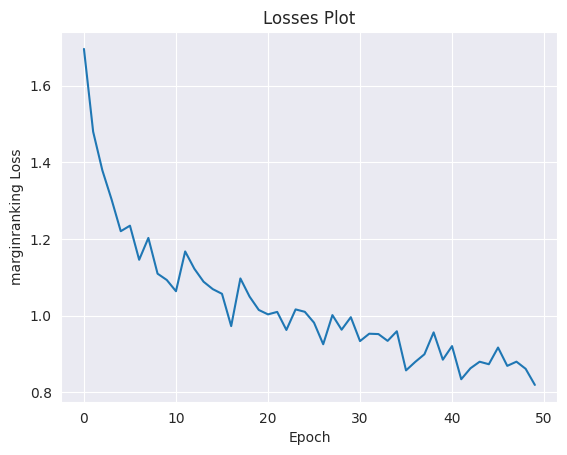

In [11]:
result.plot_losses()
plt.show()

In [12]:
result.metric_results.to_df()

,Side,Type,Metric,Value
0,head,optimistic,z_geometric_mean_rank,0.460870
1,tail,optimistic,z_geometric_mean_rank,2.644154
2,both,optimistic,z_geometric_mean_rank,2.246284
3,head,realistic,z_geometric_mean_rank,0.460874
4,tail,realistic,z_geometric_mean_rank,2.644154
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,0.441398
221,both,realistic,adjusted_hits_at_k,0.484395
222,head,pessimistic,adjusted_hits_at_k,0.527993
223,tail,pessimistic,adjusted_hits_at_k,0.441398


In [34]:
from pykeen.hpo import hpo_pipeline_from_config

In [33]:
config = {
    'optuna': dict(
        n_trials=5,
    ),
    'pipeline': dict(
        training = tf_train,
        validation = tf_valid,
        testing = tf_test,
        model='TransR',
        model_kwargs_ranges=dict(
               embedding_dim=dict(type=int, low=20, high=160, q=20),
        ),
        optimizer='Adam',
        optimizer_kwargs=dict(lr=0.01),
        loss='marginranking',
        loss_kwargs=dict(margin=1),
        training_loop='slcwa',
        training_kwargs=dict(num_epochs=100, batch_size=128),
        negative_sampler='basic',
        negative_sampler_kwargs=dict(num_negs_per_pos=1),
        evaluator_kwargs=dict(filtered=True),
        evaluation_kwargs=dict(batch_size=128),
        stopper='early',
        stopper_kwargs=dict(frequency=5, patience=2, relative_delta=0.002),
    )
}

In [35]:
hpo_pipeline_result = hpo_pipeline_from_config(config)

[I 2023-02-02 11:48:50,403] A new study created in memory with name: no-name-ce86071b-113e-43a3-adea-27f872da1cf2
No random seed is specified. Setting to 1425790650.
Training epochs on cuda:0:   0%|                     | 0/100 [00:04<?, ?epoch/s]
[W 2023-02-02 11:48:57,322] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/usr/local/lib/python3.8/dist-packages/pykeen/hpo/hpo.py", line 259, in __call__
    result = pipeline(
  File "/usr/local/lib/python3.8/dist-packages/pykeen/pipeline/api.py", line 1291, in pipeline
    losses = training_loop_instance.train(
  File "/usr/local/lib/python3.8/dist-packages/pykeen/training/training_loop.py", line 378, in train
    result = self._train(
  File "/usr/local/lib/python3.8/dist-packages/pykeen/training/training_loop.py", line 642, in _train
    batch_l

KeyboardInterrupt: 

In [30]:
hpo_pipeline_result.save_to_directory('hpo_results')

In [39]:
from pykeen.pipeline import pipeline_from_config

In [44]:
config2 = {
    "metadata": {
    "title": "nations - try",
    "comments": "comment"
  },
  "pipeline": {
    "dataset": "nations",
    "model": "TransE",
    "model_kwargs": {
      "embedding_dim": 50,
      "scoring_fct_norm": 1
    },
    "optimizer": "SGD",
    "optimizer_kwargs": {
      "lr": 0.01
    },
    "loss": "MarginRankingLoss",
    "loss_kwargs": {
      "reduction": "mean",
      "margin": 1
    },
    "training_loop": "slcwa",
    "negative_sampler": "basic",
    "negative_sampler_kwargs": {
      "num_negs_per_pos": 1
    },
    "training_kwargs": {
      "num_epochs": 100,
      "batch_size": 32
    },
    "evaluator_kwargs": {
      "filtered": True
    }
  }
}

pipeline_result = pipeline_from_config(config2)

INFO:pykeen.pipeline.api:Running: nations - try
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation
Training epochs on cuda:0:  48%|███▊    | 48/100 [00:10<00:11,  4.43epoch/s, loss=0.891, prev_loss=0.901]


Training batches on cuda:0:   0%|                                              | 0/50 [00:00<?, ?batch/s]


Training epochs on cuda:0: 100%|███████| 100/100 [00:22<00:00,  4.50epoch/s, loss=0.794, prev_loss=0.775]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=201.
Evaluating on cuda:0: 100%|████████████████████████████████████████| 201/201 [00:00<00:00, 8.27ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


In [46]:
pipeline_result.metric_results.to_df()

,Side,Type,Metric,Value
0,head,optimistic,z_geometric_mean_rank,0.630263
1,tail,optimistic,z_geometric_mean_rank,3.690055
2,both,optimistic,z_geometric_mean_rank,3.158749
3,head,realistic,z_geometric_mean_rank,0.630264
4,tail,realistic,z_geometric_mean_rank,3.690055
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,0.627598
221,both,realistic,adjusted_hits_at_k,0.578141
222,head,pessimistic,adjusted_hits_at_k,0.527993
223,tail,pessimistic,adjusted_hits_at_k,0.627598


## Result tracking

In [9]:
from pykeen.pipeline import pipeline
from pykeen.datasets import get_dataset
from pykeen.trackers import ResultTracker


dataset = get_dataset(dataset="nations")

pipeline_result = pipeline(
    model='RotatE',
    dataset=dataset,
    result_tracker="console",
    result_tracker_kwargs = dict(metric_filter='.*head.realistic.hits_at_10.*'),
    training_kwargs = dict(
        num_epochs = 5,
        callbacks="validation-loss",
        callback_kwargs=dict(
            evaluation_triples=dataset.validation.mapped_triples,
            prefix="validation",
        ),
    )    
)



INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation
INFO:pykeen.pipeline.api:Using device: None


Parameter: dataset = nations
Parameter: dataset_kwargs = None
Parameter: model = MuRE
Parameter: model_kwargs.random_seed = 3941871803
Parameter: model_kwargs.loss = MarginRankingLoss(
  (margin_activation): ReLU()
)
Parameter: loss_kwargs = None
Parameter: regularizer_kwargs = None
Parameter: optimizer = Adam
Parameter: optimizer_kwargs.lr = 0.001
Parameter: optimizer_kwargs.betas = (0.9, 0.999)
Parameter: optimizer_kwargs.eps = 1e-08
Parameter: optimizer_kwargs.weight_decay = 0
Parameter: optimizer_kwargs.amsgrad = False
Parameter: optimizer_kwargs.maximize = False
Parameter: optimizer_kwargs.foreach = None
Parameter: optimizer_kwargs.capturable = False
Parameter: optimizer_kwargs.differentiable = False
Parameter: optimizer_kwargs.fused = False
Parameter: training_loop = SLCWATrainingLoop
Parameter: evaluator = RankBasedEvaluator
Parameter: callbacks = validation-loss
Parameter: callback_kwargs.triples_factory = TriplesFactory(num_entities=14, num_relations=55, create_inverse_triples

KeyError: "Invalid TrainingCallback name: validation-loss. Valid choices are: ['evaluation', 'evaluationloop', 'gradientabsclipping', 'gradientnormclipping', 'stopper', 'tracker']"